### **Fraud detection in electricity and gas consumption.**

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas aross Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.  The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.

The data consists of 2 datasets, invoice data and client data. Client data consist of variables describing variables relevant to the client like the region and district he is from, client category, the date the client joined and most importantly, if the client is a fraud (named target). The invoice data contrains information about the invoices sent to the clients and number of invoices per client is different. In order to merge the two dataframe together, data engineering was utilised to gain maintain as much information as possible. Due to the fact that the transcation set has many discrete variable, encoding is going to lead to high dimension and feature selection is used later to simplify the model.

### **Data cleaning**

In [60]:
import numpy as np
import pandas as pd
import datetime

client_train_df = pd.read_csv("client_train.csv")
#client_test_df = pd.read_csv("client_test.csv")
invoice_train_df = pd.read_csv("invoice_train.csv", low_memory = False)
#invoice_test_df = pd.read_csv("invoice_test.csv")

In [61]:
def data_cleaning(invoice_df,client_df):
    
    global cateogrical, consom_lvls
    
    # drop na and duplicated rows
    invoice_df.dropna(inplace = True, ignore_index = True)
    client_df.dropna(inplace = True, ignore_index = True)
    invoice_df.drop_duplicates(inplace = True, ignore_index = True)
    client_df.drop_duplicates(inplace = True, ignore_index = True)

    return invoice_df,client_df
(invoice_train_df,client_train_df) = data_cleaning(invoice_train_df,client_train_df)

### **Exploratory Data Analysis**

In [62]:
invoice_train_df

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476733,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476734,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476735,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476736,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [63]:
client_train_df

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0


Percentage of fraudulent cases: 5.58%


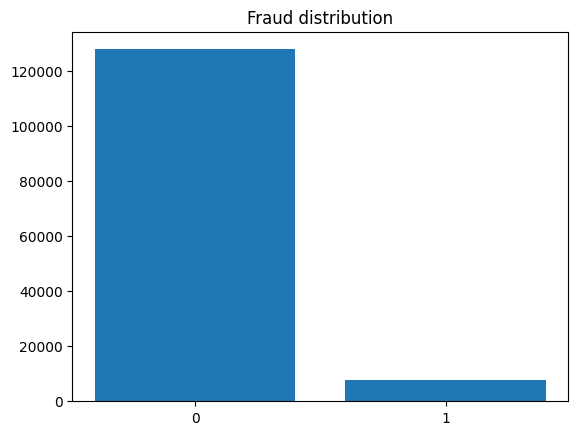

In [64]:
import matplotlib.pyplot as plt

fraud_count = client_train_df.groupby(['target'])['client_id'].count()
plt.bar(x = fraud_count.index, height = fraud_count.values, tick_label =[0,1])
plt.title('Fraud distribution')
percentage = 100 * fraud_count.values[1]/len(client_train_df.index)
print("Percentage of fraudulent cases: " + str(percentage)[:4] + '%')

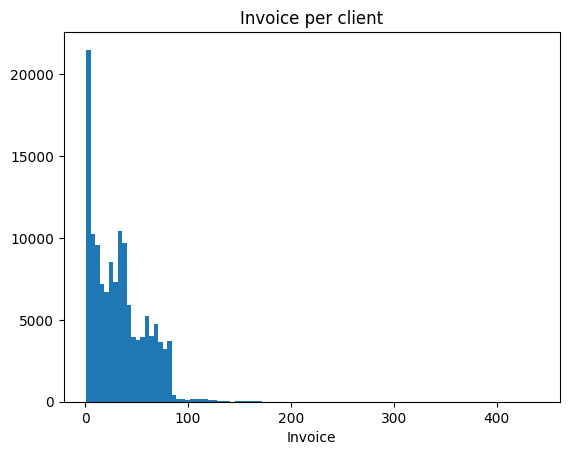

In [65]:
invoice_per_client = invoice_train_df.groupby(['client_id']).size()
plt.hist(invoice_per_client, bins = 100)
plt.title('Invoice per client')
plt.xlabel("Invoice")
plt.show()

In [69]:
fraud_region = client_train_df.groupby(['region',"target"]).size().to_frame().reset_index()
fraud_region = fraud_region.pivot_table(index = 'region', values = 0, columns = 'target',fill_value = 0)
fraud_region['percentage of fraud'] = 100 * fraud_region[1.0] / (fraud_region[0.0] + fraud_region[1.0])
fraud_region.sort_values(by = "percentage of fraud" , inplace = True, ascending = False)
print(fraud_region)

target      0.0     1.0  percentage of fraud
region                                      
103      8041.0   923.0            10.296743
372       579.0    65.0            10.093168
311     11408.0   998.0             8.044495
106       653.0    53.0             7.507082
308       780.0    61.0             7.253270
371      1917.0   148.0             7.167070
313      1929.0   147.0             7.080925
379       544.0    39.0             6.689537
304      3572.0   256.0             6.687565
107      9340.0   658.0             6.581316
307      3166.0   210.0             6.220379
302      4045.0   266.0             6.170262
305      2559.0   157.0             5.780560
104     12145.0   720.0             5.596580
105      1553.0    92.0             5.592705
303      5656.0   326.0             5.449682
310      4604.0   247.0             5.091734
312      4161.0   218.0             4.978306
306      5750.0   294.0             4.864328
309      3511.0   158.0             4.306351
101     32

### **Feature Engineering**

In [70]:
cateogrical = ["tarif_type","counter_statue","counter_code","reading_remarque","counter_coefficient","counter_type"]
consom_lvls = ["consommation_level_1","consommation_level_2","consommation_level_3","consommation_level_4"]

In [71]:
def feature_engineering(invoice_df,client_df):
    
    global cateogrical, consom_lvls                                                   

    invoice_df["invoice_date"] = pd.to_datetime(invoice_df["invoice_date"],format = '%Y-%m-%d', dayfirst = True)
    client_df.drop("creation_date", axis = 1, inplace = True)  
    invoice_df.sort_values(by = ["client_id","invoice_date"], ignore_index = True , inplace = True)
    invoice_df.reset_index(drop = True, inplace = True)
    
    invoice_df['delta_index'] =  invoice_df['new_index'] - invoice_df['old_index']
    invoice_df = pd.get_dummies(invoice_df, columns = cateogrical, dtype = "int", drop_first = True)
    client_df["region"] = client_df["region"] // 200 * 200
    client_df = pd.get_dummies(client_df, columns = ['disrict', 'client_catg', 'region'], dtype = "int", 
                               drop_first = True)
    invoice_columns = list(invoice_df.columns)
    
    updated_cateogrical = invoice_columns[11:]
    cateogrical_data = invoice_df.groupby(by = "client_id")[updated_cateogrical].sum()
    size = invoice_df.groupby(by = "client_id").size()
    cateogrical_data = cateogrical_data.merge(size.to_frame(), on = "client_id")
    cateogrical_data = cateogrical_data[updated_cateogrical].div(size, axis = 0)
    cateogrical_data.reset_index(inplace = True)
    
    stats = invoice_df.groupby(by = "client_id")[invoice_columns[2:11]].agg(['mean','std','min','max'])
    stats.reset_index(inplace = True)
    stats.columns = stats.columns.map(lambda x: x[0] + " " + str(x[1]) if x[0] != "client_id" else x[0]).str.strip('|')
    
    invoice_df = stats.merge(cateogrical_data, on = "client_id").reset_index(drop = True)
    merged_df = invoice_df.merge(client_df, on = ["client_id"])
    merged_df.fillna(0, inplace = True)
    merged_df.drop("client_id", axis = 1, inplace = True)
    
    return merged_df
    
training_df = feature_engineering(invoice_train_df, client_train_df)

### **Splitting Data**
The training data is split in 80-20 train and test data split for testing models' performance evaluation. The initial testing dataset given does not include the oberseved y (fraud) value so the testing data will have to come from the training set.

In [51]:
# Split dataset into 80% training and 20% testing

split_row = 0.8 * (len(training_df.index))
train_df = training_df.loc[:split_row,:]
test_df = training_df.loc[split_row:,:]

x_train = train_df.loc[:,train_df.columns != "target"]
y_train = train_df.loc[:,"target"]
x_test = test_df.loc[:,test_df.columns != "target"]
y_test = test_df.loc[:,"target"]

In [52]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)

### **Feature Selection**
Highly correlated variables are removed by calculating correlation coefficient with a confidence interval of 0.05. Next, to determine features that are useful for prediction, penalized logistic regression with L2 norm is used instead of L1 or elastic to retain as many useful variables as possible. Given the large size of the dataset and relatively smaller number of features, curse of dimensionality should not be an issue and hence keeping more useful variables would improve the models' predictions capability. 

In [74]:
def correlation(df,threshold):

    column_name = list(df.columns)
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    df = df.drop(to_drop,axis = 1)
    
    return (df,to_drop)

(x_train,to_drop) = correlation(x_train,0.95)
x_test = x_test.drop(to_drop,axis = 1)

In [75]:
from sklearn import linear_model

def feature_selection(x_train, y_train, x_test):
    
    l2_LR = linear_model.LogisticRegression(penalty="l2", tol=0.01, solver="saga")
    l2_LR.fit(x_train, y_train)
    coef_l2_LR = l2_LR.coef_.ravel()
    x_train = x_train.iloc[:,list(np.where(coef_l2_LR != 0)[0])]
    x_test = x_test.iloc[:,list(np.where(coef_l2_LR != 0)[0])]
    
    return (x_train, x_test)
    
(x_train, x_test) = feature_selection(x_train, y_train, x_test)

### **Model training**
The training dataset is relatively large at 100K+ rows which deters the usage of computationally heavy machine learning algorithm like support vector machines and deep learning network, high dimensionality also reduces the performance of certain models like KNN. The model has to perform well in a heavily biased testing data set where only 5% of clients are fraudulent, the trade-off between precision and recall is dependent on the electrical company's priority to either maximizing number of positive fraudulent cases (reducing loses from frauds) or minimizing wrongly predicted negative cases. As this priority is unknown, f1-score is used for the models' evualtion to have a balance between precision and recall.

In [76]:
from sklearn import metrics

def performance_metrics(y_pred, y):

    # calculate the different performance metrics 
    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)

    # Printing out the metrics
    print("-------------------------------")
    print("Accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 Score: " + str(f1))
    print("-------------------------------")
    
    return

In [96]:
from imblearn.over_sampling import RandomOverSampler
from sklearn import model_selection

def model_training(x_train, y_train, model, oversample):

    # Oversample the minority class (Fraudulent cases)
    rand = RandomOverSampler()

    # K-fold cross validation
    kfold = model_selection.KFold(n_splits = 5)
    
    for train, valid in kfold.split(x_train):
        if oversample:
            x_train_res, y_train_res  = rand.fit_resample(x_train.iloc[train,:], y_train.iloc[train])
        else:
            x_train_res, y_train_res = x_train.iloc[train,:], y_train.iloc[train]
        model.fit(x_train_res, y_train_res)
        y_pred = model.predict(x_train.iloc[valid,:])
        performance_metrics(y_pred, y_train.iloc[valid])
    
    return 

In [88]:
def parameter_tuning(x_train, y_train, model, params):

    grid_search = model_selection.GridSearchCV(estimator=model, param_grid=param,
                           cv=5, n_jobs=-1,
                           verbose=2, scoring='f1')
    grid_search.fit(x_train, y_train)
    return grid_search
    

#### K Nearest Neighbour


In [70]:
from sklearn.neighbors import KNeighborsClassifier

model_training(x_train, y_train, KNeighborsClassifier(), True)

-------------------------------
Accuracy: 0.8671525439365284
precision: 0.17759562841530055
Recall: 0.3705211726384365
F1 Score: 0.2401055408970976
-------------------------------
-------------------------------
Accuracy: 0.8675215646478158
precision: 0.18022145857197402
Recall: 0.3943191311612364
F1 Score: 0.2473794549266247
-------------------------------
-------------------------------
Accuracy: 0.865491950735735
precision: 0.1723347344287352
Recall: 0.3755203996669442
F1 Score: 0.23624934520691462
-------------------------------
-------------------------------
Accuracy: 0.8665067576917754
precision: 0.17980582524271846
Recall: 0.3718875502008032
F1 Score: 0.2424083769633508
-------------------------------
-------------------------------
Accuracy: 0.8614788505004843
precision: 0.16666666666666666
Recall: 0.3699421965317919
F1 Score: 0.229802513464991
-------------------------------


In [71]:
model_training(x_train, y_train, KNeighborsClassifier(), False)

-------------------------------
Accuracy: 0.9437243415286682
precision: 0.5130718954248366
Recall: 0.1278501628664495
F1 Score: 0.2046936114732725
-------------------------------
-------------------------------
Accuracy: 0.9448314036625306
precision: 0.5016077170418006
Recall: 0.13032581453634084
F1 Score: 0.2068965517241379
-------------------------------
-------------------------------
Accuracy: 0.9437704691175792
precision: 0.4738372093023256
Recall: 0.1357202331390508
F1 Score: 0.21100323624595474
-------------------------------
-------------------------------
Accuracy: 0.9420637483278749
precision: 0.4827586206896552
Recall: 0.12369477911646587
F1 Score: 0.19693094629156013
-------------------------------
-------------------------------
Accuracy: 0.942663406983717
precision: 0.45348837209302323
Recall: 0.12881915772089184
F1 Score: 0.20064308681672025
-------------------------------


In [89]:
# Hyperparameter tuning
param = {
    'n_neighbors': [3,7,10],
    'p': [1,2],
}
knn_grid = parameter_tuning(x_train, y_train, KNeighborsClassifier(), param)
knn_grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'n_neighbors': 3, 'p': 2}

[CV 1/5] END ................n_neighbors=3, p=2;, score=0.228 total time=  54.9s
[CV 4/5] END ................n_neighbors=3, p=2;, score=0.212 total time=  48.1s
[CV 2/5] END ................n_neighbors=7, p=1;, score=0.186 total time= 6.5min
[CV 1/5] END ...............n_neighbors=10, p=2;, score=0.137 total time=  42.2s
[CV 2/5] END ...............n_neighbors=10, p=2;, score=0.157 total time=  44.2s
[CV 3/5] END ...............n_neighbors=10, p=2;, score=0.147 total time=  47.5s
[CV 4/5] END ...............n_neighbors=10, p=2;, score=0.142 total time= 1.0min
[CV 5/5] END ...............n_neighbors=10, p=2;, score=0.139 total time=  52.7s
[CV 2/5] END ................n_neighbors=3, p=1;, score=0.199 total time= 6.5min
[CV 5/5] END ................n_neighbors=7, p=1;, score=0.160 total time= 7.3min
[CV 5/5] END ................n_neighbors=3, p=1;, score=0.204 total time= 6.5min
[CV 4/5] END ................n_neighbors=7, p=1;, score=0.181 total time= 7.3min


In [120]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
performance_metrics(y_pred, y_test)

-------------------------------
Accuracy: 0.9427633035648387
precision: 0.4398563734290844
Recall: 0.1650943396226415
F1 Score: 0.24007839294463498
-------------------------------


#### Gradient Boosting

In [101]:
from sklearn import ensemble

model_training(x_train, y_train, ensemble.GradientBoostingClassifier(), True)

-------------------------------
Accuracy: 0.7728216246136814
precision: 0.16409231328366344
Recall: 0.7353420195439739
F1 Score: 0.26831080077254493
-------------------------------
-------------------------------
Accuracy: 0.7735135384473454
precision: 0.1614079883275579
Recall: 0.7393483709273183
F1 Score: 0.26497005988023953
-------------------------------
-------------------------------
Accuracy: 0.7748051109368513
precision: 0.16530278232405893
Recall: 0.7568692756036636
F1 Score: 0.27134328358208953
-------------------------------
-------------------------------
Accuracy: 0.7746667281701185
precision: 0.16800437796424664
Recall: 0.7397590361445783
F1 Score: 0.27382191169912296
-------------------------------
-------------------------------
Accuracy: 0.7617510032750588
precision: 0.1547327977645826
Recall: 0.731626754748142
F1 Score: 0.25544183364566814
-------------------------------


In [98]:
model_training(x_train, y_train, ensemble.GradientBoostingClassifier(), False)

-------------------------------
Accuracy: 0.9457539554407491
precision: 0.5962962962962963
Recall: 0.13110749185667753
F1 Score: 0.2149532710280374
-------------------------------
-------------------------------
Accuracy: 0.9482909728308502
precision: 0.6241830065359477
Recall: 0.1595655806182122
F1 Score: 0.2541583499667332
-------------------------------
-------------------------------
Accuracy: 0.9472300382858988
precision: 0.6083650190114068
Recall: 0.13322231473771856
F1 Score: 0.21857923497267756
-------------------------------
-------------------------------
Accuracy: 0.9453388071405507
precision: 0.5961538461538461
Recall: 0.1493975903614458
F1 Score: 0.23892100192678226
-------------------------------
-------------------------------
Accuracy: 0.945846210618571
precision: 0.5562310030395137
Recall: 0.15111478117258464
F1 Score: 0.23766233766233769
-------------------------------


In [99]:
# Hyperparameter tuning
param = {
    'learning_rate': [0.75],
    'n_estimators' : [400,500],
}
gradboost_grid = parameter_tuning(x_train, y_train, ensemble.GradientBoostingClassifier(), param)
gradboost_grid.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ...............learning_rate=0.75, n_estimators=400; total time= 5.2min
[CV] END ...............learning_rate=0.75, n_estimators=400; total time= 5.2min
[CV] END ...............learning_rate=0.75, n_estimators=400; total time= 5.2min
[CV] END ...............learning_rate=0.75, n_estimators=500; total time= 6.3min
[CV] END ...............learning_rate=0.75, n_estimators=500; total time= 6.3min
[CV] END ...............learning_rate=0.75, n_estimators=500; total time= 6.4min


{'learning_rate': 0.75, 'n_estimators': 500}

[CV] END ...............learning_rate=0.75, n_estimators=400; total time= 5.2min
[CV] END ...............learning_rate=0.75, n_estimators=500; total time= 4.6min
[CV] END ...............learning_rate=0.75, n_estimators=400; total time= 5.2min
[CV] END ...............learning_rate=0.75, n_estimators=500; total time= 4.6min


In [100]:
gradboost = ensemble.GradientBoostingClassifier(learning_rate = 0.75, min_samples_split = 5, n_estimators = 500)
gradboost.fit(x_train, y_train)
y_pred = gradboost.predict(x_test)
performance_metrics(y_pred, y_test)

-------------------------------
Accuracy: 0.9429478190272345
precision: 0.45481049562682213
Recall: 0.21024258760107817
F1 Score: 0.28755760368663597
-------------------------------


#### Logistic Regression

In [130]:
model_training(x_train, y_train, linear_model.LogisticRegression(max_iter = 800), True)

-------------------------------
Accuracy: 0.6999400341344157
precision: 0.11810681719496309
Recall: 0.6644951140065146
F1 Score: 0.20056531891360452
-------------------------------
-------------------------------
Accuracy: 0.7041376447253103
precision: 0.11520873285145301
Recall: 0.6524644945697577
F1 Score: 0.19583751253761283
-------------------------------
-------------------------------
Accuracy: 0.7082430001383828
precision: 0.11715481171548117
Recall: 0.652789342214821
F1 Score: 0.1986570378816673
-------------------------------
-------------------------------
Accuracy: 0.7032612205360026
precision: 0.11964809384164223
Recall: 0.655421686746988
F1 Score: 0.2023558586484811
-------------------------------
-------------------------------
Accuracy: 0.6995710134231283
precision: 0.11701820283155158
Recall: 0.6688687035507844
F1 Score: 0.19918849133161196
-------------------------------


In [131]:
model_training(x_train, y_train, linear_model.LogisticRegression(max_iter = 800), True)

-------------------------------
Accuracy: 0.6979565478112459
precision: 0.11770623742454728
Recall: 0.6669381107491856
F1 Score: 0.20009772782799903
-------------------------------
-------------------------------
Accuracy: 0.7030767101803589
precision: 0.11527165932452275
Recall: 0.6558061821219716
F1 Score: 0.19607843137254902
-------------------------------
-------------------------------
Accuracy: 0.7062595138152129
precision: 0.1164068299925761
Recall: 0.652789342214821
F1 Score: 0.1975806451612903
-------------------------------
-------------------------------
Accuracy: 0.7025231791134278
precision: 0.1192566578870354
Recall: 0.6546184738955824
F1 Score: 0.20175764327268225
-------------------------------
-------------------------------
Accuracy: 0.6987868444116426
precision: 0.11695232608382544
Recall: 0.6705202312138728
F1 Score: 0.19916605347068925
-------------------------------


In [133]:
# Hyperparameter tuning
param = {
    'C': [0.5,1,1.5],
    'tol' : [1e-6,1e-5,1e-4] 
}
logreg_grid = parameter_tuning(x_train, y_train, linear_model.LogisticRegression(max_iter = 800), param)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


#### Decision Tree

In [77]:
from sklearn import tree
model_training(x_train, y_train, tree.DecisionTreeClassifier(), True)

-------------------------------
Accuracy: 0.9116656672355736
precision: 0.2144638403990025
Recall: 0.21009771986970685
F1 Score: 0.21225832990538873
-------------------------------
-------------------------------
Accuracy: 0.9122653258914156
precision: 0.22134387351778656
Recall: 0.23391812865497075
F1 Score: 0.22745735174654752
-------------------------------
-------------------------------
Accuracy: 0.9130033673139905
precision: 0.2231204527081649
Recall: 0.22980849292256453
F1 Score: 0.22641509433962265
-------------------------------
-------------------------------
Accuracy: 0.9122191983025048
precision: 0.23295454545454544
Recall: 0.23052208835341365
F1 Score: 0.23173193379087603
-------------------------------
-------------------------------
Accuracy: 0.9118501775912173
precision: 0.22440944881889763
Recall: 0.23534269199009084
F1 Score: 0.22974607013301088
-------------------------------


In [78]:
model_training(x_train, y_train, tree.DecisionTreeClassifier(), False)

-------------------------------
Accuracy: 0.9092670326122053
precision: 0.23512544802867383
Recall: 0.2671009771986971
F1 Score: 0.2500953107129241
-------------------------------
-------------------------------
Accuracy: 0.9108353706351769
precision: 0.23020527859237536
Recall: 0.2623224728487886
F1 Score: 0.24521671222178834
-------------------------------
-------------------------------
Accuracy: 0.9108814982240878
precision: 0.21732405259087392
Recall: 0.23397169025811823
F1 Score: 0.22534081796311145
-------------------------------
-------------------------------
Accuracy: 0.907606439411412
precision: 0.23309859154929577
Recall: 0.26586345381526105
F1 Score: 0.2484052532833021
-------------------------------
-------------------------------
Accuracy: 0.9081599704783431
precision: 0.2237960339943343
Recall: 0.26094137076796037
F1 Score: 0.24094548227220738
-------------------------------
